# Naive Bayes classifier
# Projet final - Mobilité - Montréal
### Modélisation du mode de transport des individus


### Présenté par l'équipe 9 :
- 1842221 : Rose Hirigoyen
- 1842322 : Adem Aber Aouni
- 1842873 : Alexandre Rault
- 1854753 : Jérémie Huppé

<a id=tableMatieres></a>
## Table des matières

#### [1.  Introduction](#intro)

#### [2.  Définition de fonctions supplémentaires](#functions)
- [Chargement des packages](#packages)
- [Définition des fonctions](#functi)

#### [3.  Analyse exploratoire des données](#analysis)
- [Chargement des données](#chargement)
- [Description des variables explicatives](#descriptonVE)
- [Analyse approfondie](#analyseAp)

#### [4.  Ajout de variables explicatives](#data)
- [Distance minimale metro-train](#M_dist_metro_train)
- [Possède un permis](#P_A_PERMIS)
- [Nombre d'autos par personne](#M_AUTO_PERS)
- [Heure de départ normalisée](#D_HREDE_NORM)
- [Nombre d'autos catégorisé](#M_AUTO_MOD)
- [Nombre de résidents par municipalité](#N_RESIDENTS_DOMSM)
- [Région](#M_REGION)
- [MRC](#M_MRC)
- [Groupe d'heures](#M_GRHEURE)
- [Groupe d'âge V2](#P_GRAGE_V2)
 
#### [5. Exploration des modèles](#models)
- [Séparation de l'ensemble train en SUBtest et SUBtrain générés aléatoirement](#subsets)
- [Modèle simple](#simpleModel)
- [Génération de modèles](#modelGen)
- [Validation Croisée](#test)
- [Algorithme naïf pour calculer tous les modèles](#bruteforce)
- [Algorithme itératif](#iterative)
- [Arbre Décisionnel](#dtree)

#### [6. Discussion](#discussion)
- [Performance de Julia](#perf)
- [Problèmes rencontrés](#prob)
- [Hypothèses rejetées](#hypo)

#### [7. Conclusion](#concl)

#### [8. Références](#references)


---

<a id=intro></a>
# 1. Introduction

Une quantité phénoménale de données sont produites chaque jour, et elles sont considérées comme des ressources importantes. En combinant la science des données à ces nombreuses données il est possible d'en extraire une importante quantité d'informations. Il existe plusieurs plateformes offrant des ensembles de données. Kaggle est l'une de ces plateformes. Plus spécifiquement, Kaggle est une plateforme web qui permet aux utilisateurs de publier des jeux de données et de créer des modèles à partir de ceux-ci. Kaggle offre aussi un volet de compétitions: le modèle prédisant le mieux la réalité remporte la compétition.

Le cours *MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.* propose de réaliser une compétition Kaggle comme projet final. Cette compétition a comme objectif de créer un modèle prédisant le mode de transport emprunté par une personne à partir d'un ensemble de données. Le but du projet ainsi que ses objectifs seront détaillés ci-dessous.


### But
Le but du projet consiste à dresser la situation sur la mobilité de la grande région Montréalaise. Nous devons analyser les données de la dernière enquête Origine-Destination effectuée par Transports Québec. On souhaite identifier les facteurs influençant le mode de transport des individus. Ce type d'étude pourrait être utile notamment pour

- Identifier les incitatifs aux modes de transport alternatifs à l'auto solo.
- Définir les zones prioritaires de développement du transport collectif.
- Prévoir l’effet de l’augmentation de l’offre de transport en commun vers une zone d’emploi.

### Objectifs
Le jeu de données comporte plusieurs variables explicatives pour un échantillon de 82 846 déplacements. Pour chacun des déplacements, le mode de transport correspond à l'une des cinq catégories suivantes :

- 1. Voiture
- 2. Transport collectif
- 3. Combinaison voiture et transport collectif
- 4. Actif (Vélo et marche)
- 5. Autre (transport adapté, autobus nolisé, etc.)


L'échantillon a été partitionné en un ensemble d'entraînement et un ensemble de test. 
- L'ensemble d'entraînement contient 66 277 déplacements.
- L'ensemble de test contient 16 569 déplacements.


[Retourner à la table des matières ↑](#tableMatieres)

<a id=functions></a>
# 2. Définition de fonctions supplémentaires
- [Chargement des packages](#packages)
- [Définition des fonctions](#functi)

<a id=packages></a>
### Chargement des packages

In [1]:
# À éxécuter une seule fois pour installer tous les packages nécessaires
using Pkg;
Pkg.add("StatsBase");
Pkg.add("Random");
Pkg.add("DataStructures");
Pkg.add("BenchmarkTools");

  Updating registry at `C:\Users\ThePhosphorus\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % [======>                                  ]  14.6 %]  35.6 %====================>                    ]  48.8 %             ]  66.0 %===============================>         ]  75.9 %     ]  86.7 %]  97.6 % Resolving package versions...
  Updating `C:\Users\ThePhosphorus\.julia\environments\v1.1\Project.toml`
 [no changes]
  Updating `C:\Users\ThePhosphorus\.julia\environments\v1.1\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\ThePhosphorus\.julia\environments\v1.1\Project.toml`
 [no changes]
  Updating `C:\Users\ThePhosphorus\.julia\environments\v1.1\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\ThePhosphorus\.julia\environments\v1.1\Project.toml`
 [no changes]
  Updating `C:\Users\ThePhosphorus\.julia\environm

In [2]:
using CSV, DataFrames, Gadfly, Distributions, StatsBase, Random, DataStructures, BenchmarkTools;
set_default_plot_size(9inch, 6inch);

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\ThePhosphorus\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


<a id=functi></a>
### Définition des fonctions

In [3]:
#= Fonction permettant d'extraire la fréquence relative de chaque mode en fonction des 
classes «edges» de la variable explicatives =#

function histnorm(train::DataFrame, edges::AbstractVector, varname::Symbol)

    center = (edges[1:end-1]+edges[2:end])/2;
    c = Array{Float64}(undef,5,length(center));
    m = unique(train[:D_Mode_str]);
    
    Threads.@threads for i=1:length(m)
        @inbounds ind = train[:D_Mode_str] .== m[i];
        @inbounds x = train[ind, varname];

        h = fit(Histogram,x, edges);

        @inbounds c[i,:] = h.weights;

    end
    
    nᵢ = vec(sum(c, dims=1));
    df = DataFrame(Center = center);

    for i=1:5
        df[Symbol(m[i])] = c[i,:] ./ nᵢ;
    end

    df = melt(df, :Center);
    rename!(df, :Center => varname);
    rename!(df, :value => :proportion);
    rename!(df, :variable => :D_Mode_str);
    return df;
end

histnorm (generic function with 1 method)

In [4]:
#= Fonction permettant d'obtenir le groupe d'heure selon l'heure =#

function getGrHeure(heure::Int)
    if (heure < 500)
        return 1;
    elseif (500 <= heure && heure < 900)
        return 2;
    elseif (900 <= heure && heure < 1200)
        return 3;
    elseif (1200 <= heure && heure < 1500)
        return 4;
    elseif (1500 <= heure && heure < 1900)
        return 5;
    elseif (1900 <= heure && heure < 2400)
        return 6;
    elseif (2400 <= heure)
        return 7;
    else
        println("AUCUNE CATEGORIE TROUVEE POUR HEURE ", heure);
    end
end

getGrHeure (generic function with 1 method)

In [5]:
#= Fonction permettant d'obtenir la région selon la municipalité =#

function getRegion(secteur::Int)
    if (secteur == 101 || secteur == 102)
        return 1; # Montreal centre-ville
        elseif ((103 <= secteur && secteur <= 112) || (119 <= secteur && secteur <= 125))
            return 2; # Montreal centre
        elseif (113 <= secteur && secteur <= 118)
            return 3; # Montreal est
        elseif (126 <= secteur && secteur <= 141)
            return 4; # Montreal ouest
        elseif (301 <= secteur &&  secteur <= 310)
            return 5; # Rive-Sud
        elseif (401 <= secteur && secteur <= 408)
            return 6; # Laval
        elseif (501 <= secteur && secteur <= 576)
            return 7; # Couronne Sud
        elseif (601 <= secteur && secteur <= 691)
            return 8; # Couronne Nord
        else
            println("AUCUNE CATEGORIE TROUVEE POUR REGION ", secteur);
    end
end

getRegion (generic function with 1 method)

In [6]:
#= Fonction permettant d'obtenir la municipalité régionale de comté (MRC) selon la municipalité =#

function getMRC(secteur::Int)
    if (100 <= secteur && secteur < 200)
        return 1; # Montreal
    elseif (300 <= secteur && secteur < 400)
        return 2; # Longueuil
    elseif (400 <= secteur && secteur < 500)
        return 3; # Laval
    elseif (secteur == 501)
        return 4; # Rouville
    elseif (secteur == 511)
        return 5; # Haut-Richelieu
    elseif (521 <= secteur && secteur <= 525)
        return 6; # Vallee du richelieu
    elseif (531 <= secteur && secteur <= 532)
        return 7; # Marguerite d'Youville
    elseif (541 <= secteur && secteur <= 547)
        return 8; # Roussillon
    elseif (secteur == 551)
        return 9; # Jardins-de-Napiereville
    elseif (561 <= secteur && secteur <= 564)
        return 10; # Beauharnois-Salaberry
    elseif (571 <= secteur && secteur <= 576)
        return 11; # Vaudreuil
    elseif (secteur == 533)
        return 12; # Pierre de Saurel
    elseif (secteur == 601)
        return 13; # D'Austray
    elseif (611 <= secteur && secteur <= 612)
        return 14; # L'Assomption
    elseif (621 <= secteur && secteur <= 624)
        return 15; # Les moulins
    elseif (631 <= secteur && secteur <= 633)
        return 16; # Deux-Montagnes
    elseif (641 <= secteur && secteur <= 645)
        return 17; # Therese de Blainville
    elseif (secteur == 651)
        return 18; # Mirabel
    elseif (661 <= secteur && secteur <= 663)
        return 19; # Riviere du Nord
    elseif (671 <= secteur && secteur <= 672)
        return 20; # Montcalm
    elseif (secteur == 681)
        return 21; # Argenteuil
    elseif (secteur == 691)
        return 22; # Pays d'en haut
    elseif (secteur == 602)
        return 23; # Joliette
    elseif (secteur == 603)
        return 24; # Matawine
    else
        println("AUCUNE CATEGORIE TROUVEE POUR MRC ", secteur);
    end
end

getMRC (generic function with 1 method)

In [7]:
#= Fonction permettant d'obtenir le groupe d'âge en fonction de l'âge =#

function getGrAge(age::Int)
    if (age <= 11)
        return 1;
    elseif (12 <= age && age <= 17)
        return 2;
    elseif (18 <= age && age <= 26)
        return 3;
    elseif (27 <= age && age <= 40)
        return 4;
    elseif (41 <= age)
        return 5;
    else
        println("AUCUNE CATEGORIE TROUVEE POUR AGE ", age);
    end
end

getGrAge (generic function with 1 method)

[Retourner à la table des matières ↑](#tableMatieres)

<a id=analysis></a>
# 3. Analyse exploratoire des données
- [Chargement des données](#chargement)
- [Description des variables explicatives](#descriptonVE)
- [Analyse approfondie](#analyseAp)

<a id=chargement></a>
### Chargement des données

In [8]:
# Chargement des données
train = CSV.read("ODtrain.csv");
test = CSV.read("ODtest.csv");

# Chargement des données d"entrainement séparées statiquement en sous-ensemble afin d'effectuer un test de base 
basetrain = CSV.read("SUBTRAIN.csv");
basetest = CSV.read("SUBTEST.csv");

# Nettoyage des données
dropmissing!(train, disallowmissing = true);
dropmissing!(basetrain, disallowmissing = true);
dropmissing!(basetest, disallowmissing = true);

# Taille et nombre de paramètres des ensembles
n = size(train, 1);
p = size(train, 2);
n_test = size(test, 1);
n_basetest = size(basetest, 1);

In [9]:
# Conversion de mode sous forme de string en mode sous forme d'entier
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"];
d = Array{String}(undef,n);
Threads.@threads for i=1:length(str_mode)
    @inbounds ind = train[:D_Mode] .== i;
    @inbounds d[ind] .= str_mode[i];
end
train[:D_Mode_str] = d;
categorical!(train, :D_Mode_str);

<a id=descriptonVE></a>
### Description des variables explicatives
Le jeu de données contient 19 variables. Certaines d'entre elles font référence aux ménages, c'est-à-dire à un groupe de personnes habitant le même domicile, aux personnes et aux déplacements. Les variables correspondant aux ménages, telles que le quartier, la distance avec la station de méto la plus proche, sont identifiées par le préfixe M. Les variables explicatives correspondent à la personne effectuant le déplacement, tel l'âge et le statut possèdent le préfixe P. Les variables explicatives correspondants aux déplacements tels que l'heure et le motif possèdent le préfixe D.

Voici la description de toutes les variables dont on dispose:

- <font color=green>**IPERE**</font> : numéro unique du déplacement. Elle est constituée de 6 chiffres également et unique pour chaque déplacement.
- <font color=green>**Ménage**</font> : numéro du ménage. Elle est constituée de 6 chiffres et unique pour chaque ménage.
- <font color=green>**M_AUTO**</font> : nombre de véhicules du ménage : 0 à 14.
- <font color=green>**M_PERS**</font> : nombre de personnes du ménage : 1 à 19.
- <font color=green>**M_DOMSM**</font> : secteur municipal du ménage (113 secteurs municipaux).
- <font color=green>**M_revenu**</font> : catégories des revenus en dollars des gens intérrogés (1 : Moins de 30 000, 2 : 30 000 à 59 999, 3 : 60 000 à 89 999, 4 : 90 000 à 119 999, 5 : 120 000 à 149 999, 6 : 150 000 et plus, 7 : Refus, 8 : Ne sait pas)
- <font color=green>**M_dist_train**</font> : distance réseau de la station de train la plus proche à partir du domicile.
- <font color=green>**M_dist_metro**</font> : distance réseau de la station de métro la plus proche à partir du domicile.
- <font color=green>**M_emploiTC**</font> : accessibilité à l’emploi en transport en commun (représente le nombre d’emplois qui sont accessibles en transport en commun en moins de 45 minutes à 8 heures le matin).
- <font color=green>**M_dist_centre**</font> : distance réseau jusqu'au centre-ville (Gare Centrale) à partir du domicile.
- <font color=green>**P_RANG**</font> : numéro de la personne du ménage : 1 à 19.
- <font color=green>**P_SEXE**</font> : sexe de la personne : 1=masculin 2=féminin.
- <font color=green>**P_AGE**</font> : age de la personne : 1 à 99.
- <font color=green>**P_GRAGE**</font> : groupe d'âge de la personne. Elle contient 11 catégories (1 : 0 à 4 ans, 2 : 5 à 9 ans, 3 : 10 à 14 ans, 4 : 15 à 19 ans, 5 : 20 à 24 ans, 6 : 25 à 34 ans, 7 : 35 à 44 ans, 8 : 45 à 54 ans, 9 : 55 à 64 ans, 10 : 65 à 74 ans, 11 : 75 et plus)
- <font color=green>**P_STATUT**</font> : occupation principale de la personne. Elle contient 8 catégories (1:Travail à temps plein, 2: Travail à temps partiel, 3: Étudiant, 4: Retraité, 5: Autre, 6: Enfant de 4 ans et moins, 7 À la maison, 8: Refus).
- <font color=green>**P_PERMIS**</font> : possession d’un permis de conduire. Elle contient 5 catégories (1: Oui, 2: Non, 3: Ne sait pas, 4: Refus, 5: Non applicable(<16 ans)).
- <font color=green>**D_HREDE**</font> : heure du départ (heuresminutes = 0 à 2800).
- <font color=green>**D_MOTIF**</font> : motif du déplacement. Elle contient 13 catégories (1: Travail, 2: Rendez-vous d'affaires, 3: Sur la route, 4: École, 5: Magasinage, 6: Loisir, 7: Visite d'ami(e)s/parenté, 8: Santé, 9: Reconduire quelqu'un, 10: Chercher quelqu'un, 11: Retour au domicile, 12: Autre, 13: Indéterminé/refus/NSP).
- <font color=green>**D_Mode**</font> : mode(s) emprunté pour se déplacer (1: Automobile, 2: Transport collectif, 3: Auto & TC, 4: Actif (vélo & marche), 5: Autre).



<a id=analyseAp></a>
### Analyse approfondie
Certaines des variables fournies nous ont semblé nécessiter une analyse approfondie. Voici donc quelques graphiques nous permettant de mieux visualiser les variables <font color=green>P_AGE</font> et <font color=green>D_HREDE</font>.

<a id=Age></a>
#### P_AGE en fonction des modes de transport
Notre hypothèse était que l'âge serait un facteur prédictif important. En effet, avant 16 ans, il est impossible qu'une personne conduise, mais elle pourrait se faire reconduire par ses parents, ou encore prendre le bus scolaire. Nous voulions aussi voir s'il était possible de créer des groupes d'âge plus généraux, ce que nous avons fait plus loin avec la variable <font color=green>P_GRAGE</font>. En analysant le graphique, on remarque que __les répondants plus jeunes utilisent des modes de transport très variés, alors que plus l'âge augmente, plus les gens semblent favoriser la voiture__. Il s'agit donc d'un indice qu'il serait peut-être favorable de regrouper les répondants en fonction de leur âge.

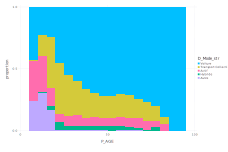

In [10]:
df = histnorm(train,0:5:99,:P_AGE)
plot(df, x = :P_AGE, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

#### D_HREDE en fonction des modes de transport
Notre hypothèse était que l'heure de départ serait un facteur prédictif important. En effet, en dehors des heures de pointe, les bus et les trains deviennent moins fréquents, ce qui les influencera à utiliser leur voiture. Nous voulions aussi voir s'il était possible de créer des groupes d'heure plus généraux, ce que nous avons fait plus loin avec la variable <font color=green>D_GRHREDE</font>. En analysant le graphique, on remarque en effet que __durant les heures de pointe, les moyens de transports sont plus variés, mais en dehors, la voiture prédomine__. Il s'agit donc d'un indice qu'il serait peut-être favorable de regrouper les répondants en fonction de leur heure de départ.

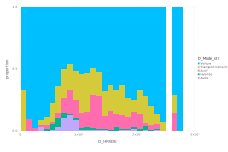

In [11]:
df = histnorm(train,0:100:2800,:D_HREDE)
plot(df, x = :D_HREDE, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

[Retourner à la table des matières ↑](#tableMatieres)

<a id=data></a>
# 4. Ajout de variables explicatives
- [Distance minimale metro-train](#M_dist_metro_train)
- [Possède un permis](#P_A_PERMIS)
- [Nombre d'autos par personne](#M_AUTO_PERS)
- [Heure de départ normalisée](#D_HREDE_NORM)
- [Nombre d'autos catégorisé](#M_AUTO_MOD)
- [Nombre de résidents par municipalité](#N_RESIDENTS_DOMSM)
- [Région](#M_REGION)
- [MRC](#M_MRC)
- [Groupe d'heures](#M_GRHEURE)
- [Groupe d'âge V2](#P_GRAGE_V2)

<a id=M_dist_metro_train></a>
### Distance minimale metro-train
Nous avons exploré cette variable, car le métro et le train font tous les deux partie de la catégorie "Transports en commun". Notre hypothèse était donc qu'il serait plus utile de considérer __la distance minimale entre les deux options__, puisqu'une personne utilisant les transports en commun va prioriser le moyen le plus proche de chez elle. 
<br>La variable <font color=green>__M_dist_metro_train__</font> correspond à la valeur minimale entre la variable <font color=green>M_dist_metro</font> (la distance au métro) et la variable <font color=green>M_dist_train</font> (la distance au train)

In [12]:
# Ajout de la variable à tous les ensembles de données

train[:M_dist_metro_train] = min.(train[:M_dist_metro], train[:M_dist_train]);
test[:M_dist_metro_train] = min.(test[:M_dist_metro], test[:M_dist_train]);
basetrain[:M_dist_metro_train] = min.(basetrain[:M_dist_metro], basetrain[:M_dist_train]);
basetest[:M_dist_metro_train] = min.(basetest[:M_dist_metro], basetest[:M_dist_train]);

#### Histogramme
On remarque que plus le répondant est proche du métro ou du train, plus il utilise des moyens de transports variés, et plus il s'éloigne, plus la voiture domine.

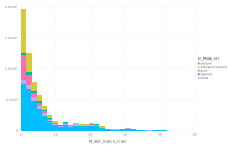

In [13]:
plot(train, x=:M_dist_metro_train, color=:D_Mode_str,
     Geom.histogram(bincount=30), Coord.cartesian(xmin=0, xmax = 50))

<a id=P_A_PERMIS></a>
### Possède un permis
Notre hypothèse était qu'en considérant seulement si les gens possèdent un permis ou non, c'est-à-dire en __généralisant les réponses en seulement 2 catégories au lieu de 5__, cela enlèverait du 'bruit' de notre modèle.
<br>La variable <font color=green>__P_A_PERMIS__</font> vaut 1 si la colonne <font color=green>P_PERMIS</font> vaut 1 (la personne a un permis) ou 2 si ce n'est pas le cas.

In [14]:
# Ajout de la variable à tous les ensembles de données

train[:P_A_PERMIS]  = min.(fill(2, n), train[:P_PERMIS]);
test[:P_A_PERMIS] = min.(fill(2, n_test), test[:P_PERMIS]);
basetrain[:P_A_PERMIS] = min.(fill(2, size(basetrain, 1)), basetrain[:P_PERMIS]);
basetest[:P_A_PERMIS] = min.(fill(2, size(basetest, 1)), basetest[:P_PERMIS]);

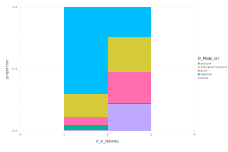

In [15]:
df = histnorm(train,0:1:4,:P_A_PERMIS);
plot(df, x = :P_A_PERMIS, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

---

<a id=M_AUTO_PERS></a>
### Nombre d'autos par personne
Notre hypothèse était que de diviser __le nombre de voitures par le nombre de personnes dans un ménage__ normaliserait la variable. Nous avons trouvé que cela représentait plus la réalité d'un ménage. Par exemple, il est facile d'avoir accès à une auto si on en a une pour un ménage de taille 1, mais difficile si on en a 3 pour un ménage de taille 8.
<br>La variable <font color=green>__M_AUTO_PERS__</font> correspond à la variable <font color=green>M_AUTO</font> divisée par la variable <font color=green>M_PERS</font>

In [16]:
# Ajout de la variable à tous les ensembles de données

train[:M_AUTO_PERS] = train[:M_AUTO] ./ train[:M_PERS];
test[:M_AUTO_PERS] = test[:M_AUTO] ./ test[:M_PERS];
basetrain[:M_AUTO_PERS] = basetrain[:M_AUTO] ./ basetrain[:M_PERS];
basetest[:M_AUTO_PERS] = basetest[:M_AUTO] ./ basetest[:M_PERS];

#### Histogramme
Les foyers possédant moins d'une auto par personne utilisent des moyens de transport plus variés que les foyers en possédant plus. 

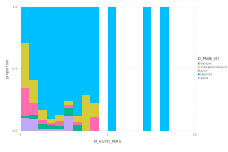

In [17]:
df = histnorm(train,0:0.5:10,:M_AUTO_PERS);
plot(df, x = :M_AUTO_PERS, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

---

<a id=D_HREDE_NORM></a>
### Heure de départ normalisée
Puisque l'heure allait de 0 à 2800, nous avons choisi de la __normaliser de 1 à 2400__ (nous ajoutons 1, car nous ne pouvons pas utiliser une catégorielle avec une catégorie qui vaut 0)
<br>La variable <font color=green>__D_HREDE_NORM__</font> correspond à la variable <font color=green>D_HREDE</font> modulo 2400 + 1

In [18]:
# Ajout de la variable à tous les ensembles de données

train[:D_HREDE_NORM] = train[:D_HREDE] .% 2400 .+1;
test[:D_HREDE_NORM] = test[:D_HREDE] .% 2400 .+1;
basetrain[:D_HREDE_NORM] = basetrain[:D_HREDE] .% 2400 .+1;
basetest[:D_HREDE_NORM] = basetest[:D_HREDE] .% 2400 .+1;

#### Histogramme
On a presque le même résultat que pour la variable <font color=green>D_HREDE</font>, soit que les moyens de transports utilisés sont plus variés durant les heures de pointe. 

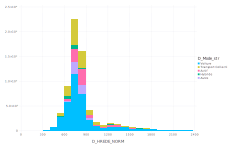

In [19]:
plot(train, x=:D_HREDE_NORM, color=:D_Mode_str,
     Geom.histogram(bincount=24), Coord.cartesian(xmin=0, xmax = 2400))

---

<a id="M_AUTO_MOD"></a>
### Nombre d'autos catégorisé
La variable <font color=green>__M_AUTO_MOD__</font> correspond à __la variable <font color=green>M_AUTO</font> + 1__ afin que le nombre d'auto ne vaille jamais 0 pour pouvoir faire une catégorielle. Les catégories sont les suivantes:<br>
1 - 0 auto<br>
2 - 1 auto<br>
3 - 2 autos<br>
...<br>
15 - 14 autos

In [20]:
# Ajout de la variable à tous les ensembles de données

train[:M_AUTO_MOD] = train[:M_AUTO] .+1;
test[:M_AUTO_MOD] = test[:M_AUTO] .+1;
basetrain[:M_AUTO_MOD] = basetrain[:M_AUTO] .+1;
basetest[:M_AUTO_MOD] = basetest[:M_AUTO] .+1;

#### Histogramme
On remarque que les foyers ayant beaucoup d'auto utilisent presque exclusivement ce mode de transport, alors que les autres ont des solutions plus variées. 

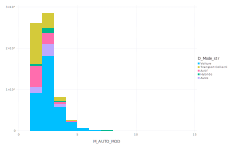

In [21]:
plot(train, x=:M_AUTO_MOD, color=:D_Mode_str,
     Geom.histogram(bincount=15), Coord.cartesian(xmin=0, xmax = 15))

---

<a id=N_RESIDENTS_DOMSM></a>
### Nombre de résidents par municipalité
Pour donner un sens à la variable <font color=green>M_DOMSM</font>, nous avons pensé qu'il serait utile d'__inclure le nombre de répondants dans la municipalité__ afin de relativiser l'impact de la variable représentant la municipalité. Pour un répondant habitant dans un quartier où 100% des gens sont actifs, ce pourcentage a plus de poids s'il vit dans une municipalité de 100 000 répondants que s'il vit dans un quartier d'un seul répondant. La variable <font color=green>__N_RESIDENTS_DOMSM__</font> correspond donc au nombre de répondants dans la même municipalité que le répondant analysé.

In [22]:
# Ajout de la variable à tous les ensembles de données

train[:N_RESIDENTS_DOMSM] = zeros(Int, size(train,1));
# on compte les résidents de chaque quartier dans un dictionnaire de fréquence ayant la forme (no municipalité => nb répondants) 
freq = counter(train[:M_DOMSM]);
for i=1:size(train,1)
    train[:N_RESIDENTS_DOMSM][i] = freq[train[:M_DOMSM][i]];
end

test[:N_RESIDENTS_DOMSM] = zeros(Int, size(test,1));
freq = counter(test[:M_DOMSM]);
for i=1:size(test,1)
    test[:N_RESIDENTS_DOMSM][i] = freq[test[:M_DOMSM][i]];
end

basetrain[:N_RESIDENTS_DOMSM] = zeros(Int, size(basetrain,1));
freq = counter(basetrain[:M_DOMSM]);
for i=1:size(basetrain,1)
    basetrain[:N_RESIDENTS_DOMSM][i] = freq[basetrain[:M_DOMSM][i]];
end

basetest[:N_RESIDENTS_DOMSM] = zeros(Int, size(basetest,1));
freq = counter(basetest[:M_DOMSM]);
for i=1:size(basetest,1)
    basetest[:N_RESIDENTS_DOMSM][i] = freq[basetest[:M_DOMSM][i]];
end

#### Histogramme
On peut seulement faire ressortir le fait que dans toutes les municipalités, une grande proportion des gens utilisent la voiture, mais il est difficile de faire un lien entre le nombre d'habitants et le mode de transport choisi.

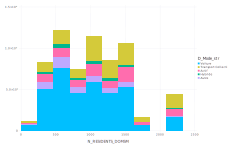

In [23]:
plot(train, x=:N_RESIDENTS_DOMSM, color=:D_Mode_str,
     Geom.histogram(bincount=10), Coord.cartesian(xmin=0, xmax = 2500))

---

<a id=M_REGION></a>
### Région
Notre hypothèse était que __les gens d'une même région utilisaient peut-être des moyens de transport semblables__. Par exemple, les résidents de la région de Montréal ont accès à un service de transports en commun plus complet que ceux de la région de Longueuil par exemple, ce qui peut avoir une influence sur les résultats. La variable <font color=green>__M_REGION__</font> correspond donc à la valeur de la région, qui peut prendre l'une des 8 valeurs suivantes:  
1 - Montreal centre-ville<br>
2 - Montreal centre<br>
3 - Montreal est<br>
4 - Montreal ouest<br>
5 - Rive-Sud<br>
6 - Laval<br>
7 - Couronne Sud<br>
8 - Couronne Nord<br>
Ces valeurs ont été choisies selon les données fournies par l'enquête.

In [24]:
# Ajout de la variable à tous les ensembles de données

train[:M_REGION] = getRegion.(train[:M_DOMSM]);
test[:M_REGION] = getRegion.(test[:M_DOMSM]);
basetrain[:M_REGION] = getRegion.(basetrain[:M_DOMSM]);
basetest[:M_REGION] = getRegion.(basetest[:M_DOMSM]);

#### Histogramme
On remarque que les personnes habitant la région de Montréal semblent avoir une plus grande proportion actifs et utilisant les transports collectifs que les autres régions. 

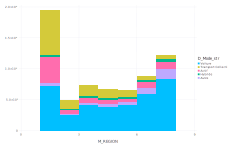

In [25]:
plot(train, x=:M_REGION, color=:D_Mode_str,
     Geom.histogram(bincount=8), Coord.cartesian(xmin=0, xmax = 9))

---

<a id=M_MRC></a>
### MRC
Notre hypothèse était la même que pour la variable <font color=green>M_REGION</font>, mais appliquée à la __MRC de chaque répondant__. La variable <font color=green>__M_MRC__</font> correspond donc à la MRC de chaque répondant, qui peut prendre l'une des 24 valeurs suivantes:
<pre>
1 - Montreal                9  - Jardins-de-Napiereville    17 - Therese de Blainville
2 - Longueuil               10 - Beauharnois-Salaberry      18 - Mirabel
3 - Laval                   11 - Vaudreuil                  19 - Riviere du Nord
4 - Rouville                12 - Pierre de Saurel           20 - Montcalm
5 - Haut-Richelieu          13 - D'Austray                  21 - Argenteuil
6 - Vallee du richelieu     14 - L'Assomption               22 - Pays d'en haut
7 - Marguerite d'Youville   15 - Les moulins                23 - Joliette
8 - Roussillon              16 - Deux-Montagnes             24 - Matawine
</pre>

Ces valeurs ont été choisies selon les données fournies par l'enquête.

In [26]:
# Ajout de la variable à tous les ensembles de données

train[:M_MRC] = getMRC.(train[:M_DOMSM]);
test[:M_MRC] = getMRC.(test[:M_DOMSM]);
basetrain[:M_MRC] = getMRC.(basetrain[:M_DOMSM]);
basetest[:M_MRC] = getMRC.(basetest[:M_DOMSM]);

#### Histogramme
Encore une fois, on remarque que les personnes habitant la région de Montréal semblent avoir une plus grande proportion actifs et utilisant les transports collectifs que les autres régions. 

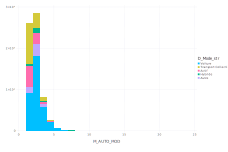

In [27]:
plot(train, x=:M_AUTO_MOD, color=:D_Mode_str,
     Geom.histogram(bincount=24), Coord.cartesian(xmin=0, xmax = 25))

---

<a id=M_GRHEURE></a>
### Groupe d'heures
Notre hypothèse était que __les gens partant dans les mêmes groupes d'heures utilisaient peut-être des moyens de transports semblables__. Par exemple, les gens qui partent dans les heures de pointes (par exemple entre 5h et 9h) ont accès à plus de bus que ceux partant plus tard, ce qui peut avoir une influence sur les résultats. La variable <font color=green>__M_GRHEURE__</font> correspond donc à la valeur du groupe d'heure, qui peut prendre l'une des 7 valeurs suivantes:  
1 - De minuit à 4h59 du matin inclusivement<br>
2 - De 5h à 8h59 du matin inclusivement<br>
3 - De 9h à 11h59 du matin inclusivement<br>
4 - De 12h à 15h de l'après-midi inclusivement<br>
5 - De 15h à 18h59 du soir inclusivement<br>
6 - De 19h à 23h59 minuit exclusivement<br>
7 - De minuit à 28h inclusivement (Puisque nous ne comprenions pas vraiment cette valeur, nous avons gardé les mêmes groupes que l'enquête afin de ne perdre aucune information)<br>
Ces valeurs ont été choisies selon les données fournies par l'enquête.

In [28]:
# Ajout de la variable à tous les ensembles de données

train[:M_GRHEURE] = getGrHeure.(train[:D_HREDE]);
test[:M_GRHEURE] = getGrHeure.(test[:D_HREDE]);
basetrain[:M_GRHEURE] = getGrHeure.(basetrain[:D_HREDE]);
basetest[:M_GRHEURE] = getGrHeure.(basetest[:D_HREDE]);

#### Histogramme
On remarque comme prévu que les répondants appartenant au premier groupe d'heure utilisent des modes vraiment plus variés que les autres, qui semblent favoriser la voiture.

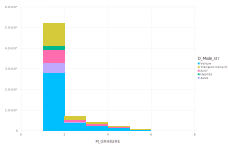

In [29]:
plot(train, x=:M_GRHEURE, color=:D_Mode_str,
     Geom.histogram(bincount=7), Coord.cartesian(xmin=0, xmax = 8))

---

<a id=P_GRAGE_V2></a>
### Groupe d'âge V2
Notre hypothèse était que __les gens faisant partie des mêmes groupes d'âges__ utilisaient peut-être des moyens transports semblables. Par exemple, les jeunes de moins de 16 ans ne peuvent pas conduire, ce qui peut avoir une influence sur les résultats. La variable <font color=green>__P_GRAGE_V2__</font> correspond donc à la valeur du groupe d'âge, qui peut prendre l'une des 5 valeurs suivantes:  
1 - 11 ans et moins<br>
2 - De 12 à 17 ans<br>
3 - De 18 à 26 ans<br>
4 - De 27 à 40 ans<br>
5 - 41 ans et plus<br>

Il y a déjà une variable nommée <font color=green>P_GRAGE</font>, qui continent les groupes d'âges définis par l'enquête. Or, nous avons choisi de redéfinir cette variable après avoir observé des regroupements dans les données. Nous avons également créé des groupes assez gros pour pouvoir entrainer des modèles distincts pour chaque groupe (voir section *Arbre décisionnel*).

In [30]:
# Ajout de la variable à tous les ensembles de données

train[:P_GRAGE_V2] = getGrAge.(train[:P_AGE]);
test[:P_GRAGE_V2] = getGrAge.(test[:P_AGE]);
basetrain[:P_GRAGE_V2] = getGrAge.(basetrain[:P_AGE]);
basetest[:P_GRAGE_V2] = getGrAge.(basetest[:P_AGE]);

#### Histogramme
On remarque beaucoup de choses intéressantes. Tout d'abord, les deux premiers groupes d'âge utilisent beacoup plus les modes actifs et autres. De plus, le premier groupe n'utilise presque pas les transports en communs, et plus l'âge avance, plus la voiture prédomine. 

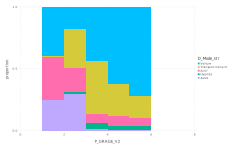

In [31]:
df = histnorm(train,:1:8,:P_GRAGE_V2)
plot(df, x = :P_GRAGE_V2, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

[Retourner à la table des matières ↑](#tableMatieres)

---

<a id=models></a>
# 5. Exploration des modèles
- [Séparation de l'ensemble train en SUBtest et SUBtrain générés aléatoirement](#subsets)
- [Modèle simple](#simpleModel)
- [Génération de modèles](#modelGen)
- [ Validation Croisée](#test)
- [Algorithme naïf pour calculer tous les modèles](#bruteforce)
- [Algorithme itératif](#iterative)
- [Arbre Décisionnel](#dtree)

<a id=subsets></a>
### Séparation de l'ensemble train en SUBtest et SUBtrain générés aléatoirement
Nous savions d'avance que nous voulions tester nos modèles avant de les envoyer sur Kaggle, afin de ne pas gaspiller nos essais limités. Nous avons donc séparé l'ensemble train en un ensemble SUBtrain, utilisé pour entraîner nos modèles, et en un ensemble SUBtest, utilisé pour tester la fiabilité de nos modèles. Pour ce faire, nous avons ajouté une colonne contenant un nombre aléatoire à l'ensemble train, puis nous avons ordonné nos données selon cette colonne. Finalement nous avons pris __70% des données pour faire l'ensemble SUBtrain, et 30% des données pour faire l'ensemble SUBtest__.<br><br>
Bien que cette manière de faire nous ait permis de tester nos premiers modèles, cette manière de faire n'est pas optimale. En effet, puisque les ensembles SUBtest et SUBtrain sont toujours les mêmes, il est __impossible de savoir si la performance du modèle est représentative pour toutes les données, ou seulement pour cet ensemble__. Par exemple, on pourrait avoir un excellent score de prédiction pour SUBtest parce que le modèle est très fiable pour cet ensemble de données, mais un très mauvais score sur Kaggle, parce que le modèle était peut-être trop spécifique.

In [32]:
#= fonction permettant de mélanger un dataframe =#

function shuffleDF(d::DataFrame)
    d.Order = shuffle!(collect(1:size(d,1)));
    sort!(d, (:Order));;
    deletecols!(d, :Order);
    return d;
end

shuffleDF (generic function with 1 method)

<a id=simpleModel></a>
### Modèle simple
Pour le premier modèle que nous avons essayé, nous avons utilisé __l'estimation par maximum de vraisemblance pour estimer les paramètres__. Nous n'avons utilisé qu'une seule variable, :M_dist_centre, la distance minimale entre le metro et le train, et nous avons posé qu'elle suivait une Normale pour le mode de transport "Autre" et une Gamma pour les autres, basé sur les résultats obtenus avec l'utilisation de la fonction *findBestDistr* définie dans la section suivante. Ce premier essai nous a permis de vraiment comprendre le processus de prédiction.

In [33]:
#= fonction permettant d'évaluer le pourcentage de succès des prédictions =#

function getSimilarity(results, test)
    return count(test[:D_Mode] .== results)/size(test,1);
end

getSimilarity (generic function with 1 method)

In [34]:
# taux d'utilisation pour chaque mode
d = basetrain[:,:D_Mode];
n_mode = Float64[];
for i=1:5
    push!(n_mode, count(d .== i));
end
α = n_mode/size(basetrain,1);
M = Categorical(α);

# prédiction par le mode de la distribution
mode(M);

# création du modèle
x = Array{Float64,1}[];
for i=1:5
    ind = basetrain[:D_Mode] .== i;
    push!(x, basetrain[ind,:M_dist_centre]);
end

# définition du vecteur fd
fd = vcat(fit(Gamma,x[1]), fit(Gamma,x[2]), fit(Gamma,x[3]), fit(Gamma,x[4]), fit(Normal,x[5]));


# prédiction
x = basetest[:,:M_dist_centre];
ntest = length(x);
y = Array{Int64}(undef,ntest);
for i=1:ntest
    p = α .* pdf.(fd,x[i]);
    _, ind = findmax(p);
    y[i] = ind;
end
predictions = DataFrame(IPERE = basetest[:IPERE], D_Mode =  y);

# indice de fiabilité
getSimilarity(predictions[:D_Mode], basetest);

<a id=modelGen></a>
### Génération de modèles
Nous avons voulu rendre la génération de modèles plus simple et plus rapide. 
Notre objectif a été de créer la fonction **defineModel** qui modélise automatiquement les variables explicatives que nous lui passons en paramètre. Pour ce faire, nous avons utilisé le critère du BIC. En effet, la fonction **findBestDistr** sélectionne la distribution avec le plus grand BIC et attribue celle-ci à la variable correspondante. Cela nous a permis d'automatiser la sélection des distributions et la génération d'un modèle. Voici le détail des fonctions utilisées:

In [35]:
#= Défini les données en X pour une variable dans un certain ensemble d'entraînement =#

function defineX(var, train)
    x = Array{Float64,1}[];
    for i=1:5
        ind = train[:D_Mode] .== i;
        push!(x,train[ind,var]);
    end
    return x;
end

defineX (generic function with 1 method)

In [36]:
#= fonction permettant de calcuer le BIC avec la formule présentée en classe =#

function BIC(fd, x::Array, k::Int, n::Int)
    return (loglikelihood(fd, x) - k*log(n)/2);
end

BIC (generic function with 1 method)

In [37]:
#= fonction permettant de trouver la meilleure distribution pour un ensemble de données =#

function findBestDistr(data::Array, verbose::Bool)
    # Definition des modèles à essayer
    distr = [Beta, Binomial, 
              Categorical, DiscreteUniform, Exponential, 
              Normal, Gamma, Geometric, Laplace, Pareto, 
              Poisson, Uniform, Multinomial, MvNormal, Dirichlet, Weibull];
    
    distrNames = ["Beta", "Binomial", 
                  "Categorical", "DiscreteUniform", "Exponential", 
                  "Normal", "Gamma", "Geometric", "Laplace", "Pareto", 
                  "Poisson", "Uniform", "Multinomial", "MvNormal", "Dirichlet", "Weibull"];
    
    # Déclaration des variables
    maxBIC = -Inf;
    distrName = nothing;
    finalfd = nothing;
    fitDist = nothing;
    
    for i = 1:length(distr) # Pour chaque type de modèle
        if (verbose)
            println("Trying model of type: ", distrNames[i]);
        end
        try # On essaie de faire fit le modèle sur les données
            fitDist = fit(distr[i], data);
        catch
            if (verbose)
                println("Invalid");
            end
            continue
        end
        
        k = sizeof(fieldnames(distr[i]))[1]; # le nombre de paramètres dans le modèle
        nData = sizeof(data)[1]; # le nombre de données dans l'ensemble
        newBIC = BIC(fitDist, data, k, nData); # calcul du BIC
        
        # Si on trouve un meilleur BIC que celui qu'on a déjà, le modèle courant est le meilleur
        if (newBIC > maxBIC) 
            maxBIC = newBIC;
            distrName = distrNames[i];
            finalfd = fitDist;
        end
    end
    
    # Décommenter cette ligne pour voir quel est le modèle trouvé
    # println("The best model is of type ", distrName, " with a BIC of ", maxBIC)
    return finalfd;
end

findBestDistr (generic function with 1 method)

In [38]:
#= Pour une variable, on retourne la densité de la fonction pour chaque mode =#

function getFdVec(x)
    return vcat(findBestDistr(x[1], false), 
                findBestDistr(x[2], false),
                findBestDistr(x[3], false),
                findBestDistr(x[4], false),
                findBestDistr(x[5], false));
end

getFdVec (generic function with 1 method)

In [39]:
#= fonction permettant de définir les x et les fd pour un modèle selon les paramètres utilisés. =#

function defineModel(train, test, params)
    
    x_curr = defineX(params[1], train);
    fd_curr = getFdVec(x_curr);
    x_curr = test[:, params[1]];

    x = x_curr;
    fd = fd_curr;
    
    for i=2:length(params)
        x_curr = defineX(params[i], train);
        fd_curr = getFdVec(x_curr);
        x_curr = test[:, params[i]];
        
        x = hcat(x, x_curr);
        fd = hcat(fd, fd_curr);
    end
    return x, fd;
end

defineModel (generic function with 1 method)

Cela nous permet donc de calculer le modèle de la manière suivante:

In [40]:
# Définition de α
dAlpha = basetrain[:,:D_Mode];
n_mode = Float64[];
for i=1:5
    push!(n_mode, count(dAlpha .== i));
end
α = n_mode/size(basetrain,1);
M = Categorical(α);
mode(M);

# définition du modèle
params = [:M_dist_centre];
x, fd = defineModel(basetrain, basetest, params);

y = Array{Int64}(undef,size(basetest,1));

# Optimisation des paramètres 
Threads.@threads for i=1:size(basetest,1)
    p = α;

    for j=1:size(x,2)
        @inbounds p = p .* pdf.(fd[:,j], x[i,j]);
    end

    _, ind = findmax(p);
    @inbounds y[i] = ind;

end

# Comparaison des résultats
predictions = DataFrame(IPERE = basetest[:IPERE], D_Mode =  y);
getSimilarity(predictions[:D_Mode], basetest);

<a id=test></a>
### Validation Croisée
Afin d'améliorer la fonction de test, nous avons voulu augmenter la couverture et la robustesse du test. Pour régler le problème soulevé avec l'utilisation de la méthode précédente, nous avons utilisé une méthode de test itérative. En effet, __le modèle est testé 10 fois avec des ensembles d'entraînement et de test générés aléatoirement à chaque fois__. Cela nous permet d'avoir une meilleure idée de la performance de notre modèle et nous évite aussi d'avoir un indice de performance biaisé par l'utilisation des mêmes données.<br> Bien sûr, ne faire que 10 itérations ne nous permettra jamais d'être sûrs à 100% de la fiabilité de l'indice de performance du modèle, mais il réduit grandement les chances que l'indice soit trompeur. Nous aurions pu le faire plus de fois pour être encore plus certains, mais nous avons jugé que 10 itérations étaient un bon compromis entre la performance du programme et le résultat obtenu, qui est assez fiable.

Nous utilisons donc les fonctions suivantes afin de générer et de tester notre modèle:

In [41]:
#= fonction permettant d'obtenir des statistiques sur les résultats des tests, 
soit la fiabilité moyenne, maximale et minimale après un certain nombre d'itérations =#

function getStatistics(scores::Array)
    # [ avg, max, min]
    return [sum(scores)/size(scores,1), maximum(scores), minimum(scores)] ;
end

getStatistics (generic function with 1 method)

In [42]:
#= fonction permettant d'obtenir le score prédictif d'un ensemble de variables. Elle prend en paramètre une liste de 
variables sous forme de Symboles et retourne l'indice de fiabilité du modèle =#

function getModelScore(params::Array{Symbol,1})
    scores = Float64[];
    for i=1:10
        
        # Définition de subtest et subtrain
        prop = 0.3; # entre 0.0 et 1.0, proportion de test par rapport a train (ex: 0.3 = 30% test et 70% train)
        
        ntest = trunc(Int, prop*n); # nombre de données dans l'ensemble test
        shuffletrain = shuffleDF(train);
        
        subtest = shuffletrain[1:ntest,:];
        subtrain = shuffletrain[ntest+1:n, :];

        # Définition de α
        dAlpha = subtrain[:,:D_Mode];
        n_mode = Float64[];
        for i=1:5
            push!(n_mode, count(dAlpha .== i));
        end
        α = n_mode/size(subtrain,1);
        M = Categorical(α);
        mode(M);

        # Définition du modèle selon les paramètres choisis
        x, fd = defineModel(subtrain, subtest, params);

        y = Array{Int64}(undef,size(subtest,1));

        # Optimisation des paramètres 
        Threads.@threads for i=1:size(subtest,1)
            p = α;

            for j=1:size(x,2)
                @inbounds p = p .* pdf.(fd[:,j], x[i,j]);
            end

            _, ind = findmax(p);
            @inbounds y[i] = ind;

        end

        # Comparaison des résultats
        predictions = DataFrame(IPERE = subtest[:IPERE], D_Mode =  y);
        append!(scores, getSimilarity(predictions[:D_Mode], subtest));
    end

    return getStatistics(scores);
end

getModelScore (generic function with 1 method)

On teste maintenant le modèle comme suit, ou les 3 résultats obtenus sont la moyenne, le maximum et le minimum de l'indice de fiabilité:

In [43]:
params = [:M_AUTO, :M_revenu, :M_dist_centre, :P_SEXE, :P_AGE, :P_PERMIS];
getModelScore(params)

3-element Array{Float64,1}:
 0.6335764220691043
 0.6380827842880853
 0.6307901222149574

<a id=bruteforce></a>
### Algorithme naïf pour calculer tous les modèles
Avec cette nouvelle méthode, il était désormais très facile de tester toutes sortes de modèles. Or, nous cherchions le meilleur modèle. Nous avons essayé la méthode naïve, c'est-à-dire de __tester toutes les combinaisons possibles de variables__. Nous avons donc fait une fonction qui retourne tous les sous-ensembles qu'il est possible de créer à partir d'un ensemble, puis nous avons tenté de trouver l'indice de fiabilité de chacun afin de ne garder que le plus haut.

In [44]:
#= fonction permettant d'obtenir tous les sous-ensembles possibles
[https://discourse.julialang.org/t/generate-all-subsets-of-a-set/12810] =#

function powerset(x::Vector{T}) where T
    result = Vector{T}[[]];
    for elem in x, j in eachindex(result)
        push!(result, [result[j] ; elem]);
    end
    return result;
end

powerset (generic function with 1 method)

In [45]:
#= fonction permettant de trouver le meilleur modèle parmi tous les ensembles de variables passés en paramètre =#

function getBestOf(pset)
    maxStats = [0, 0, 0];
    idxBest = 1;

    for i=2:size(pset,1)
        try
            newStats = getModelScore(pset[i]);
            print(string(i), " - ", pset[i], ": ", string(newStats[1]));
            if (newStats[1] > maxStats[1]) 
                maxStats = newStats ;
                idxBest = i;
                print(" - Nouveau meilleur modèle!\n");
            else
                print("\n");
            end
        catch
            println("Skipping model ", pset[i]);
            continue
        end
    end

    println("============================");
    println("Best model: ", pset[idxBest]);
    println("Avg:   ", string(maxStats[1]));
    println("Best:  ", string(maxStats[2]));
    println("Worst: ", string(maxStats[3]));
end

getBestOf (generic function with 1 method)

In [46]:
params = [:M_AUTO, :M_PERS, 
          :M_DOMSM, :M_revenu, 
          :M_dist_train, :M_dist_metro, 
          :M_dist_centre, :M_emploiTC, 
          :P_RANG, :P_SEXE, 
          :P_AGE, :P_GRAGE, 
          :P_STATUT, :P_PERMIS, 
          :D_HREDE, :D_MOTIF, 
          :M_AUTO_PERS, :P_A_PERMIS];


# Décommenter cette ligne pour essayer la fonction, risque de faire planter le kernel!
# getBestOf(models)

# Exemple de la fonction en action
params = [ :M_AUTO, :M_revenu, :P_AGE];
models = powerset(params);
println(models);
getBestOf(models)

Array{Symbol,1}[[], [:M_AUTO], [:M_revenu], [:M_AUTO, :M_revenu], [:P_AGE], [:M_AUTO, :P_AGE], [:M_revenu, :P_AGE], [:M_AUTO, :M_revenu, :P_AGE]]
2 - Symbol[:M_AUTO]: 0.5822360810742846 - Nouveau meilleur modèle!
3 - Symbol[:M_revenu]: 0.5452497108082281
4 - Symbol[:M_AUTO, :M_revenu]: 0.5821204043655385
5 - Symbol[:P_AGE]: 0.5356334557159383
6 - Symbol[:M_AUTO, :P_AGE]: 0.6052708343811297 - Nouveau meilleur modèle!
7 - Symbol[:M_revenu, :P_AGE]: 0.5382336669516672
8 - Symbol[:M_AUTO, :M_revenu, :P_AGE]: 0.6074385153145904 - Nouveau meilleur modèle!
Best model: Symbol[:M_AUTO, :M_revenu, :P_AGE]
Avg:   0.6074385153145904
Best:  0.6144445003269124
Worst: 0.6000100588442387


Bien sûr, cette méthode a de gros désavantages. Premièrement, elle __prend beaucoup de temps et demande beaucoup de puissance de calcul__. Sur un seul ordinateur, nous avons estimé qu'il faudrait environ 25 jours pour calculer tous les modèles possibles. Afin de la rendre viable, nous avons dû faire un petit [système réparti](#rep) avec 27 ordinateurs de l'école afin de diviser la charge de travail, ce qui nous a permis d'estimer qu'il faudrait 22 heures pour tout calculer, ce qui est tout de même très long. Deuxièmement, elle __ne nous aide pas vraiment à comprendre l'impact des variables sur un modèle__ et va donc un peu à l'encontre de l'esprit du concours. La fonction calcule tous les modèles possibles, ce qui nous fournit beaucoup d'informations à la fin de son exécution, mais si nous voulons ajouter une nouvelle variable, par exemple, cela ajoute énormément de calculs. Il s'agit d'une approche naïve et inefficace qu'il faut absolument améliorer.

<a id=iterative></a>
### Algorithme Itératif

Puisque l'algorithme testant toutes les combinaisons devient beaucoup trop long à exécuter avec un grand nombre de variables explicatives, nous avons utilisé une autre approche pour nous permettre de sélectionner les variables explicatives.

<br></br>
L'algorithme suivant commence par évaluer le modèle avec toutes les variables explicatives fournies, puis retire une à une les variables explicatives qui une fois retirées augmentent le pourcentage de prévision. Supposons que nous fournissions p variables explicatives, alors le premier modèle sera estimer avec p variables explicatives. Ensuite, toutes les combinaisons possibles de p-1 variables explicatives seront testées et la meilleure combinaison sera retenue. Cet algorithme est répété jusqu'à ce qu'il ne reste que la combinaison optimale des variables explicatives.

<br></br>
Cet algorithme est moins long à executer et nous a donc permis de gagner énormèment de temps. Aussi, on peut voir directement quelles sont les variables explicatives retirées du modèle et l'ordre de retrait représente plus ou moins la grandeur de l'impact négatif de la variable. Un désavantage de notre algorithme est que nous n'enlevons pas les variables explicatives qui n'ont pas d'impact. Il est donc possible que certaines variables explicatives inutiles restent dans le modèle final sélectionné.

<br></br>
Lors de cette itération nous avons aussi implémenté la fonction *getFdCat* qui nous a permis d'obtenir la fonction de densité d'une loi catégorielle correspondant à une variable donnée. Cela nous a permis de forcer la distribution catégorielle pour certaines variables en ajoutant celles-ci dans la variable *colonnes_variables_cat_age*. 
<br></br>


In [47]:
#= fontion permettant de trouver la meilleur distribution pour une variable x donnée, 
   si aucune distribution n'est trouvée, retourner une loi uniforme basée sur la taille du vecteur x. =#

function findBestDistIfExists(x, verbose, n_x)
    if size(x, 1) != 0
        return findBestDistr(x, verbose)
    end
    return Uniform(0, n_x)
end

findBestDistIfExists (generic function with 1 method)

In [48]:
#= Pour une variable, on retourne la densité de la fonction pour chaque mode =#

function getFdVec(x, n_x)
    return vcat(findBestDistIfExists(x[1], false, n_x), 
                findBestDistIfExists(x[2], false, n_x),
                findBestDistIfExists(x[3], false, n_x),
                findBestDistIfExists(x[4], false, n_x),
                findBestDistIfExists(x[5], false, n_x))
end

getFdVec (generic function with 2 methods)

In [49]:
#= fontion permettant de d'ajuster l'ensemble de données d'une variable x pour une distribution donnée, 
   si la distribution ne peut être ajustée à cet ensemble de donnée, 
   retourner une loi uniforme basée sur la taille du vecteur x. =#

function fitIfExists(dist, x, n_x)
    if size(x, 1) != 0
        return fit(dist, x)
    end
    return Uniform(0, n_x)
end

fitIfExists (generic function with 1 method)

In [50]:
#= Pour une variable, on retourne la densité categorielle pour chaque mode =#

function getFdCat(x, n_x)
    xInt =  Array{Int64,1}[]
    
    for i=1:size(x,1)
       push!(xInt, fill(0, size(x[i],1)))
       for j=1:size(x[i],1)
          xInt[i][j] = floor(Int, x[i][j])
       end
    end
    
    return vcat(fitIfExists(Categorical, xInt[1], n_x), 
                fitIfExists(Categorical, xInt[2], n_x),
                fitIfExists(Categorical, xInt[3], n_x),
                fitIfExists(Categorical, xInt[4], n_x),
                fitIfExists(Categorical, xInt[5], n_x)) 
end

getFdCat (generic function with 1 method)

In [51]:
#= fonction permettant de définir les x et les fd pour un modèle selon les paramètres utilisés. =#

function defineModel(trainSet, testSet, combinaison, variables, variablesCat)
    x = fill(-1, size(trainSet, 2))
    fd = fill(-1, size(trainSet, 2))
    # Création du modèle
    for i=1:size(combinaison, 1)
        if combinaison[i]
            xᵢ = defineX(variables[i], trainSet)
            fdᵢ = fill(-1, 2)
            if variables[i] in variablesCat
                fdᵢ = getFdCat(xᵢ, size(trainSet, 2))
            else
                fdᵢ = getFdVec(xᵢ, size(trainSet, 2))
            end           
            
            xᵢ = testSet[:, variables[i]];
            if x[1] !== -1
                x = hcat(x,xᵢ)
                fd = hcat(fd,fdᵢ)
            else
                x = xᵢ
                fd = fdᵢ
            end
        end
    end
    
    return x, fd
end

defineModel (generic function with 2 methods)

In [52]:
#= fonction permettant de tester une combinaison de variables données. =#

function testCombinaison(trainSet, combinaison, variables, variablesCat)
    scores = Float64[]

    for i=1:10
        # Définition de subtest et subtrain
        prop = 0.3  # entre 0.0 et 1.0, proportion de test par rapport a train (ex: 0.3 = 30% test et 70% train)
        n_train = size(trainSet, 1)
        ntest = trunc(Int, prop*n_train)
        shuffleTrain = shuffleDF(copy(trainSet))
        subtest = shuffleTrain[1:ntest,:]
        subtrain = shuffleTrain[ntest+1:n_train, :]

        # Définition de α
        dAlpha = subtrain[:,:D_Mode];
        n_mode = Float64[];
        for i=1:5
            push!(n_mode, count(dAlpha .== i));
        end
        α = n_mode/size(subtrain,1);
        M = Categorical(α);
        mode(M);

        x, fd = defineModel(subtrain, subtest, combinaison, variables, variablesCat)
    
        y = Array{Int64}(undef,size(subtest,1));

        # Optimisation des paramètres 
        for i=1:size(subtest,1)
            p = α
        
            for j=1:size(x,2)
                p = p .* pdf.(fd[:,j], x[i,j])
            end
        
            _, ind = findmax(p);
            y[i] = ind;

        end

        # Comparaison des résultats
        predictions = DataFrame(IPERE = subtest[:IPERE], D_Mode =  y);
        append!(scores, getSimilarity(predictions[:D_Mode], subtest))
    end

    return getStatistics(scores)[1]
end

testCombinaison (generic function with 1 method)

In [53]:
#= fonction permettant de tester un ensemble de combinaisons pour un ensemble de variables données. =#

function everyCombinaisons(trainSet, variables, variablesCat)
    n_variables = size(variables,1);
    bestCombinaison = trues(n_variables);
    bestAvg = testCombinaison(trainSet, bestCombinaison, variables, variablesCat);
    println(bestCombinaison);
    println(bestAvg);
    
    indexToRemove = 1;
    while indexToRemove != 0
        indexToRemove = 0;
        tempBestCombination = copy(bestCombinaison);
        for i=1:n_variables
            combinaison = copy(bestCombinaison);
            if combinaison[i]
                combinaison[i] = false;
                if !(true in combinaison)
                    break;
                end
                currentAvg = testCombinaison(trainSet, combinaison, variables, variablesCat);
                if currentAvg > bestAvg + 0.001
                    tempBestCombination = copy(combinaison);
                    bestAvg = currentAvg;
                    indexToRemove = i;
                end
            end
        end
        if indexToRemove != 0 
            println("removed ", variables[indexToRemove]);
            bestCombinaison = tempBestCombination;
            println(bestCombinaison);
            println(bestAvg);
        end
    end
    println("Best combination:");
    println(bestCombinaison);
    println("avg:  ", bestAvg);
    return bestCombinaison, bestAvg;
end

everyCombinaisons (generic function with 1 method)

In [54]:
#= fonction permettant d'afficher le résultat obtenu =#

function logResult(bestCombinaison, avg, colonnes_variables_age)
    println("--------------------------");
    println("Variable Rejetées: ", colonnes_variables_age[bestCombinaison .== false]);
    println("Variable acceptées: ", colonnes_variables_age[bestCombinaison .== true]);
    println(" ");
    println("avg: ", avg);
    println("--------------------------");
end

logResult (generic function with 1 method)

In [55]:
# Définition des variables explicatives utilisées
colonnes_variables_cat_age = [:M_DOMSM, :D_HREDE_NORM, :P_GRAGE, :P_PERMIS, :M_AUTO_MOD, :P_SEXE];
colonnes_variables_age = [];
append!(colonnes_variables_age, colonnes_variables_cat_age);

In [56]:
# Note: il est normal que cette cellule prenne du temps à s'exécuter
#= Exécution afin de trouver la meilleure combinaison de variables =#
@time bestCombinaison, avg = everyCombinaisons(train, colonnes_variables_age, colonnes_variables_cat_age);
logResult(bestCombinaison, avg, colonnes_variables_age);

Bool[true, true, true, true, true, true]
0.6547352009254136
Best combination:
Bool[true, true, true, true, true, true]
avg:  0.6547352009254136
552.039599 seconds (154.50 M allocations: 143.588 GiB, 87.42% gc time)
--------------------------
Variable Rejetées: Any[]
Variable acceptées: Any[:M_DOMSM, :D_HREDE_NORM, :P_GRAGE, :P_PERMIS, :M_AUTO_MOD, :P_SEXE]
 
avg: 0.6547352009254136
--------------------------


<a id=dtree></a>
### Arbre Décisionnel


Nous avons constaté que notre modèle prédictif avait atteint une limite à un niveau de précision d'environ 65.5%, voir section [Algorithme Itératif](#iterative). 

Rappelons-nous que nous avions constaté qu'il y avait une différence significative par rapport au moyen de transport emprunté par un individu en fonction de son âge, voir variable [P_AGE](#Age). 

Après une analyse approndie des différents groupes d'âge nous avons décidé de catégoriser l'âge en 5 sous-groupes, voir la variable [P_GRAGE_V2](#P_GRAGE_V2).

Nous avons donc eu l'intuition de générer des modèles différents pour chacune de ces catégories d'âges. 
Avant de procéder à l'implémentation de cet ensemble de modèles nous avons effectué une recherche afin de confirmer notre intuition. Il s'est avéré que cette procédure a été proposée par Ron Kohavi <a id=1>[1]</a>. Cette procédure propose de combiner un arbre décisionnel avec des modèles bayésien naïf. Cette combinaison consiste à développer un modèle bayésien naïf à chaque feuille de l'arbre de décisionnel <a id=1>[1]</a>. 

Nous avons donc développé cinq modèles bayésien naïf, un pour chaque groupe d'âge:

- Age1 [1 à 11]  -> ModèleAge1
- Age2 [12 à 17] -> ModèleAge2
- Age3 [18 à 26] -> ModèleAge3
- Age4 [27 à 40] -> ModèleAge4
- Age5 [41, 150] -> ModèleAge5


Voici comment nous avons implémenté cet arbre décisionnel :

In [57]:
#= fonction permettant d'afficher le résultat obtenu =#

function logResult(bestCombinaison, avg, colonnes_variables_age, i)
    println("--------------------------");
    println("Age", i);
    println("Variable Rejetées: ", colonnes_variables_age[bestCombinaison .== false]);
    println("Variable acceptées: ", colonnes_variables_age[bestCombinaison .== true]);
    println(" ");
    println("avg:", i, " ", avg);
    println("--------------------------");
end

logResult (generic function with 2 methods)

In [58]:
#= Définition de tous les sous ensembles nécessaires pour la génération des cinq modèles bayésien naïf =#

trainAge1 = train[train[:P_GRAGE_V2] .== 1, :];
trainAge2 = train[train[:P_GRAGE_V2] .== 2, :];
trainAge3 = train[train[:P_GRAGE_V2] .== 3, :];
trainAge4 = train[train[:P_GRAGE_V2] .== 4, :];
trainAge5 = train[train[:P_GRAGE_V2] .== 5, :];

testAge1 = test[test[:P_GRAGE_V2] .== 1, :];
testAge2 = test[test[:P_GRAGE_V2] .== 2, :];
testAge3 = test[test[:P_GRAGE_V2] .== 3, :];
testAge4 = test[test[:P_GRAGE_V2] .== 4, :];
testAge5 = test[test[:P_GRAGE_V2] .== 5, :];

basetestAge1 = basetest[basetest[:P_GRAGE_V2] .== 1, :];
basetestAge2 = basetest[basetest[:P_GRAGE_V2] .== 2, :];
basetestAge3 = basetest[basetest[:P_GRAGE_V2] .== 3, :];
basetestAge4 = basetest[basetest[:P_GRAGE_V2] .== 4, :];
basetestAge5 = basetest[basetest[:P_GRAGE_V2] .== 5, :];

basetrainAge1 = basetrain[basetrain[:P_GRAGE_V2] .== 1, :];
basetrainAge2 = basetrain[basetrain[:P_GRAGE_V2] .== 2, :];
basetrainAge3 = basetrain[basetrain[:P_GRAGE_V2] .== 3, :];
basetrainAge4 = basetrain[basetrain[:P_GRAGE_V2] .== 4, :];
basetrainAge5 = basetrain[basetrain[:P_GRAGE_V2] .== 5, :];

In [59]:
# Définition des variables pour le groupe d'âge 1
colonnes_variables_cat_age1 = [:P_STATUT, :D_HREDE_NORM, :P_AGE, :M_DOMSM, :M_revenu, :M_AUTO_MOD];
colonnes_variables_age1 = [];
append!(colonnes_variables_age1, colonnes_variables_cat_age1);

# Définition des variables pour le groupe d'âge 2
colonnes_variables_cat_age2 = [:M_PERS, :D_HREDE_NORM, :P_AGE, :P_PERMIS, :M_MRC, :M_AUTO_MOD];
colonnes_variables_age2 = [];
append!(colonnes_variables_age2, colonnes_variables_cat_age2);

# Définition des variables pour le groupe d'âge 3
colonnes_variables_cat_age3 = [:P_SEXE, :D_MOTIF, :P_PERMIS, :M_MRC, :M_AUTO_MOD];
colonnes_variables_age3 = [];
append!(colonnes_variables_age3, colonnes_variables_cat_age3);

# Définition des variables pour le groupe d'âge 4
colonnes_variables_cat_age4 = [:P_STATUT, :P_AGE, :P_PERMIS, :M_AUTO_MOD, :P_SEXE];
colonnes_variables_age4 = [];
append!(colonnes_variables_age4, colonnes_variables_cat_age4);

# Définition des variables pour le groupe d'âge 5
colonnes_variables_cat_age5 = [:D_HREDE_NORM, :P_PERMIS, :M_revenu, :M_AUTO_MOD];
colonnes_variables_age5 = [];
append!(colonnes_variables_age5, colonnes_variables_cat_age5);

In [60]:
#= Exécution des cinq modèles afin de trouver les meilleures combinaisons de variables pour chaque modèles=#

@time bestCombinaison1, avg1 = everyCombinaisons(trainAge1, colonnes_variables_age1, colonnes_variables_cat_age1);
logResult(bestCombinaison1, avg1, colonnes_variables_age1, 1);

@time bestCombinaison2, avg2 = everyCombinaisons(trainAge2, colonnes_variables_age2, colonnes_variables_cat_age2);
logResult(bestCombinaison2, avg2, colonnes_variables_age2, 2);


@time bestCombinaison3, avg3 = everyCombinaisons(trainAge3, colonnes_variables_age3, colonnes_variables_cat_age3);
logResult(bestCombinaison3, avg3, colonnes_variables_age3, 3);

@time bestCombinaison4, avg4 = everyCombinaisons(trainAge4, colonnes_variables_age4, colonnes_variables_cat_age4);
logResult(bestCombinaison4, avg4, colonnes_variables_age4, 4);


@time bestCombinaison5, avg5 = everyCombinaisons(trainAge5, colonnes_variables_age5, colonnes_variables_cat_age5);
logResult(bestCombinaison5, avg5, colonnes_variables_age5, 5);


avg = (
    avg1 * size(trainAge1, 1) 
    + avg2 * size(trainAge2, 1)
    + avg3 * size(trainAge3, 1) 
    + avg4 * size(trainAge4, 1)
    + avg5 * size(trainAge5, 1)
) / size(train, 1);


println("**************************");
println("avg: ", avg);
println("**************************");

Bool[true, true, true, true, true, true]
0.541209173036831
Best combination:
Bool[true, true, true, true, true, true]
avg:  0.541209173036831
 13.301568 seconds (22.82 M allocations: 14.139 GiB, 45.05% gc time)
--------------------------
Age1
Variable Rejetées: Any[]
Variable acceptées: Any[:P_STATUT, :D_HREDE_NORM, :P_AGE, :M_DOMSM, :M_revenu, :M_AUTO_MOD]
 
avg:1 0.541209173036831
--------------------------
Bool[true, true, true, true, true, true]
0.5330751355538342
removed M_PERS
Bool[false, true, true, true, true, true]
0.5349341595662277
Best combination:
Bool[false, true, true, true, true, true]
avg:  0.5349341595662277
205.769953 seconds (30.04 M allocations: 20.548 GiB, 95.37% gc time)
--------------------------
Age2
Variable Rejetées: Any[:M_PERS]
Variable acceptées: Any[:D_HREDE_NORM, :P_AGE, :P_PERMIS, :M_MRC, :M_AUTO_MOD]
 
avg:2 0.5349341595662277
--------------------------
Bool[true, true, true, true, true]
0.6974200581395349
Best combination:
Bool[true, true, true, true,

Il nous est donc possible de conclure qu'en moyenne notre abre de décision prédit correctement: 
- 54% des individus du groupe d'âge 1 
- 53% des individus du groupe d'âge 2
- 70% des individus du groupe d'âge 3 
- 74% des individus du groupe d'âge 4 
- 77% des individus du groupe d'âge 5

Il est possible de soulever que de notre modèle a de la difficulté à prédire le mode de transport emprunté par les individus faisant partie des groupes d'age 1 et 2. En effet, les enfants empruntent plusieurs moyens de transport différents. Approximativement 28% des enfants empruntent la voiture,  15% empruntent le transport en commun, 27% sont actifs et 26% empruntent un moyen de transport autre. Il est donc possible d'affirmer que la répartition est relativement uniforme entre les moyens de transport empruntés par les enfants ce qui explique pourquoi notre modèle a de la difficulté à prédire le mode de transport qu'ils empruntent.

[Retourner à la table des matières ↑](#tableMatieres)

---

<a id=discussion></a>
# 6. Discussion
- [Performance de Julia](#perf)
- [Problèmes rencontrés](#prob)
- [Hypothèses rejetées](#hypo)


<a id=perf></a>
### Performance de Julia
Puisque nous avons travaillé avec des fonctions couteûses en terme de calculs et de performance. Nous avons donc dû trouver des solutions nous permettant de __diminuer le travail à faire par le processeur__, ou du moins, de le répartir. La plupart des algorithmes utilisés peuvent être facilement parallélisés, c'est-à-dire que l'on peut séparer l'exécution en plus petites parties que l'on peut rouler en même temps, nous permettant de réduire le temps nécessaire pour exécuter une fonction, ou de répartir la tâche entre plusieurs ordinateurs.

<a id=rep></a>
#### Solution #1 : Système réparti
Lors de l'implémentation de l'algorithme naïf, nous avons rencontré le problème selon lequel le test des 260 000 modèles prenait beaucoup trop de temps. La solution que nous avons trouvée a été de __répartir le travail sur les ordinateurs de l'école, c'est-à-dire que pour les 27 ordinateurs du L-4714, chacun était chargé de calculer le résultat de 10 000 modèles__.
Pour ce faire, nous avons écrit un script qui envoyait des requêtes _secure shell (ssh)_ aux ordinateurs et lançait le script Julia calculant les modèles. Afin de ne pas monopoliser les ressources, chaque ordinateur ne calculait que 100 modèles à la fois, et nous repartions la tâche à toutes les 5 minutes. Nous avons inclus le script à des fins de documentation, bien qu'en bout de ligne nous ne l'ayons pas utilisé.

```bash
#!/bin/bash

depart=0
size=50

if [ $# == 1 ]; then
	depart=$1
fi

# Execution de la commande pour lancer julia et executer notre code via connection ssh
for i in {1..27}
do
	min=$(( $depart + 1 + ( $i - 1 ) * $size))
	max=$(( $depart + $i * $size))
	sshpass -pPASSWORD ssh USER@l4714-$(printf "%02d" $i).info.polymtl.ca "echo -e \"$min\n$max\n\" | ~/mth3302/julia-bin/julia-1.1.0/bin/julia ~/mth3302/getbestmodel.jl > ~/mth3302/res/$min-$max.txt" &
	echo $i
	sleep 1
done

# Attendre ques les connexions ssh soient fermées (Une fois les calculs finis)
while [[ $(ps | grep ssh) != "" ]]
do
	sleep 1
done

echo done
```

#### Solution #2 : Travail sur carte graphique

Au lieu de devoir utiliser plusieurs ordinateurs différents, nous avons essayé d'utiliser plusieurs __threads__ d'un même processeur afin de prendre moins de temps à entraîner nos modèles.

Il possible de voir le nombre de thread utilisés par julia grâce à la fonction suivante:

In [62]:
# Obtenir le nombre de thread utilisé par julia
Threads.nthreads()

6

Nous pouvons voir la différence de performance en exécutant le test d'un modèle quelconque

In [63]:
#= Cette méthode permet d'obtenir l'indice de précision d'un modèle sous forme de pourcentage =#

function compareArr(a, b, verbose)
    pourcent = count(a .== b)/size(a,1) * 100;
    if(verbose)
        println("Le modéle est précis à $pourcent %");
    end
    return pourcent;
end

compareArr (generic function with 1 method)

In [64]:
#= Cette méthode permet de rouler le test sur le modèle de manière séquentielle (sans multithread) =#

function sequential_test!(test::DataFrame, fd::Array)
    nTest = size(test,1);
    x = test[:,:M_dist_centre];
    y = Array{Int64}(undef,nTest);
    
    
    for i=1:nTest
        p = pdf.(fd,x[i]);
        _, ind = findmax(p);
        y[i] = ind;
    end
    
    compareArr(y, test[:D_Mode], false);
end

sequential_test! (generic function with 1 method)

In [65]:
#= Cette méthode permet de rouler le test sur le modèle de manière parallèle (avec multithread) =#

function parallel_test!(test::DataFrame, fd::Array)
    nTest = size(test,1);
    x = test[:,:M_dist_centre];
    y = Array{Int64}(undef,nTest);
    
    Threads.@threads for i=1:nTest
        @inbounds p = pdf.(fd,x[i]);
        _, ind = findmax(p);
        @inbounds y[i] = ind;
    end
    
    compareArr(y, test[:D_Mode], false);
end

parallel_test! (generic function with 1 method)

In [66]:
# Test
x = Array{Float64,1}[];
for i=1:5
    ind = train[:D_Mode] .== i;
    push!(x,train[ind,:M_dist_centre]);
end

fd = vcat(fit(Gamma,x[1]), fit(Gamma,x[2]), fit(Gamma,x[3]), fit(Gamma,x[4]), fit(Normal,x[5]));

In [67]:
# Sans multithreading
@btime sequential_test!($basetest,$fd);

  34.140 ms (416530 allocations: 10.31 MiB)


In [68]:
# Avec multithreading
@btime parallel_test!($basetest, $fd);

  8.309 ms (130056 allocations: 3.35 MiB)


Nous pouvons voir qu'en parallélisant sur plusieurs threads, l'exécution du test nous prend 4 fois moins de temps (pour 6 threads). La prochaine étape a été d'essayer de paralléliser les calculs sur une carte graphique afin d'obtenir encore plus de puissance de calcul. Afin de pouvoir faire cela, nous avons utilisé CuArrays. Malheureusement, La carte graphique utilisée n'était pas encore supportée par CuArrays (RTX 2060). Ainsi, ils nous a été impossible de l'utiliser pour effectuer des calculs. Cependant, avec plus de temps et de ressources, il aurait été intéressant de voir quelle performance on aurait pu atteindre en l'exécutant sur une carte graphique.

---

<a id=prob></a>
### Problèmes rencontrés
Nous avons rencontrés quelques problèmes tout au long de notre projet. 
Le plus important d'entre eux a été la performance. Nous avons essayé d'optimiser le plus possibles nos méthodes de calcul afin de rendre le _Jupyter Notebook_ facilement exécutable, mais après un certain temps d'utilisation, il fallait inévitablement redémarrer le noyau au risque de perdre le travail accompli.

<br>
Un autre problème rencontré a été l'analyse de données. En effet, nous avons par utilié en grande partie le logiciel Excel pour créer nos graphiques et analyser nos données, à cause de la performance très moyenne que nous avons obtenu avec Jupyter pour créer des graphiques. Le notebook est très bien pour visualiser les données et ajouter des figures explicatives au rapport, mais pour faire de l'analyse approfondie et avoir une meilleure idée de comment séparer les groupes, Excel nous a été d'une plus grande aide.

<br>

Finalement, l'utilisation de Julia nous a causé quelques problèmes au début, communs à l'apprentissage de nouveaux languages de programmation. Nous avons pris __un certain temps__ à saisir comment bien manipuler les tableaux, et cela a nécessité un peu de déboguage. Néamoins, nous sommes très satisfaits des apprentissages réalisés, et alors que Julia gagne en popularité en entreprise, il s'agit d'un bon avantage.

---

<a id=hypo></a>
### Hypothèses rejetées

#### Prédiction du mode de transport des enfants en fonction de celui des parents

Comme nous l'avons constaté précédemment, notre modèle avait de la difficulté à prédire le mode de transport 
pour les groupes d'âge 1 et 2. Les groupes d'âge 1 et 2 regroupent tous les individus de moins de 18 ans, soit les enfants. 
Afin d'améliorer nos prédictions pour ces deux groupes d'âge nous avons posé l'hypothèse que le déplacement des enfants dépend du déplacement des adultes faisant partie du même ménage. Plus précisément, nous voulions identifier les ménages avec seulement des adultes n'utilisant pas la voiture afin de pouvoir conclure que les enfants de ce ménage n'allaient probablement pas se rendre à l'école en voiture.

Pour ce faire nous avons prédit le moyen de transport emprunté par les groupes d'âge 4 et 5, soit les adultes âgés de 27 ans et plus. Ensuite, nous avons utilisé cette prédiction pour définir la nouvelle variable explicative 
<font color=green>__:Adult_Takes_Car__</font> pour les groupes d'âge 1 et 2. Après avoir ajouté cette variable à notre modèle, nous avons constaté que celle-ci n'apportait aucune information supplémentaire. Nous avons alors investigué la situation et nous avons découvert qu'environ 25% des enfants n'avaient pas de parents dans l'ensemble de données. La nouvelle variable n'apportait donc aucune information pour 25% des enfants. De plus, il y avait seulement une petite proportion des enfants qui faisaient partie d'un ménage avec des adultes n'utilisant pas la voiture  (environ 7,8%). Somme toute, cette variable explicative ne nous a pas permis d'augmenter le pouvoir prédictif de notre modèle.

*Note: Des ajustements ont été apporté au code original afin qu'il puisse être présenté dans cette section*

In [69]:
#= fonction permettant d'obtenir la prédiction effectuée par le modèle qui a été déterminé par la fonction defineModel =#
function getPredictionSet(trainSet, bestCombinaison, colonnes_variables, colonnes_variables_cat)
    # Définition de α
    dAlpha = trainSet[:,:D_Mode];
    n_mode = Float64[];
    for i=1:5
        push!(n_mode, count(dAlpha .== i));
    end
    α = n_mode/size(trainSet,1);
    M = Categorical(α);
    mode(M);

    x, fd = defineModel(trainSet, trainSet, bestCombinaison, colonnes_variables, colonnes_variables_cat)

    y = Array{Int64}(undef,size(trainSet,1));

    # Optimisation des paramètres 
    for i=1:size(trainSet,1)
        p = α

        for j=1:size(x,2)
            p = p .* pdf.(fd[:,j], x[i,j])
        end

        _, ind = findmax(p);
        y[i] = ind;

    end

    # Comparaison des résultats
    predictions = DataFrame(IPERE = trainSet[:IPERE], D_Mode_Prediction =  y)
    return predictions
end


getPredictionSet (generic function with 1 method)

In [70]:
#= fonction egroupe les prediction en deux sous-groupes : 1: adulte va travailler avec voiture ou 2: adulte ne va pas 
travailler pas en voiture =#
function getGrModePrediction(prediction::Int)
    if (prediction == 1 || prediction == 3) # Va travailler en auto ou hybride
        return 1
    elseif (prediction == 2 || prediction == 4 || prediction == 5) # Va travailler en TC, Actif ou Autre
        return 2
    else
        return 0 # c'est un enfant alors on ne veut pas le considérer
    end
end

getGrModePrediction (generic function with 1 method)

In [71]:
#= fonction qui retourne vrai s'il y a que des enfants dans le ménage =#
function areAllKids(x)
    xValues = x[:P_AGE]
    for i=1:size(xValues, 1)
        if(xValues[i] > 17)
            return false;
        end
    end
    
    return true
end

areAllKids (generic function with 1 method)

In [72]:
#= fonction qui regroupe   =# 
function getGrMenageGrMode(x)
    xValues = x[:D_Mode_Grp_Prediction]
    if areAllKids(x) # si le ménage contient seulement des enfants on les regroupe avec les enfants 
        return 1;    #  dont les parents vont travailler en auto ou hybride puisque les données obtenues suivent la même distributions
    elseif size(xValues[xValues .== 1], 1) == 0 # Si aucun adulte ne va travailler en voiture 
        return 2;                              # (ils vont travailler en TC, Autre ou Actif)
    else # Sinon va travailler en auto ou hybride
        return 1;
    end
end

getGrMenageGrMode (generic function with 1 method)

In [73]:
# Note: un ajustement au code original a été fait ci-dessous afin que celui-ci puisse être présenté 
# dans cette section du notebook

# Nous allons chercher les prédiction des adultes que notre modèle a fait 
predictionsTrain4 = getPredictionSet(trainAge4, bestCombinaison4, colonnes_variables_age4, colonnes_variables_cat_age4);
predictionsTrain5 = getPredictionSet(trainAge5, bestCombinaison5, colonnes_variables_age5, colonnes_variables_cat_age5);

# Nous regroupons toutes les prédictions des adultes
predictionsTrain = vcat(predictionsTrain4, predictionsTrain5);

# Nous ajoutons les prédictions au train 
train = join(train,predictionsTrain,on=:IPERE,kind=:left, makeunique = true);

# Nous remplaçons les valeurs missing (celles des enfants) par 0
train[ismissing.(train[:D_Mode_Prediction]), :D_Mode_Prediction] = 0;

# Nous groupons les prédictions en 3 sous-groupes (0: enfants, 1: Auto et hybride, 2: Actif et TC)
d = getGrModePrediction.(train[:D_Mode_Prediction]);
train[:D_Mode_Grp_Prediction] = d;

# Définition de la nouvelle variable explicative :Adult_Takes_Car
# cette à une valeur : 
# 1 si au moins un adulte emprunte la voiture ou hybride ou si le ménage ne contient que des enfants
# 2 si aucun adulte ne va travailler en voiture ou hyvride (ils vont travailler en TC, Autre ou Actif)
newVariableAdultTakesCar = by(train, :Menage , [:D_Mode_Grp_Prediction, :P_AGE] => x -> (x1Bydefault=getGrMenageGrMode(x)));
rename!(newVariableAdultTakesCar, :x1 => :Adult_Takes_Car);

# On ajoute la nouvelle variable au train set
train = join(train,newVariableAdultTakesCar,on=:Menage,kind=:left, makeunique = true);

# Redéfinir les trainSet pour Age1 et Age2 avec les nouvelles variables
trainAge1 = train[train[:P_GRAGE_V2] .== 1, :];
trainAge2 = train[train[:P_GRAGE_V2] .== 2, :];

trainAge1G1 = trainAge1[trainAge1[:Adult_Takes_Car] .== 1, :];
trainAge1G2 = trainAge1[trainAge1[:Adult_Takes_Car] .== 2, :];

trainAge2G1 = trainAge2[trainAge2[:Adult_Takes_Car] .== 1, :];
trainAge2G2 = trainAge2[trainAge2[:Adult_Takes_Car] .== 2, :];


# Ajout de la variable :Adult_Takes_Car dans les variables à considérer pour les groupes d'âge 1 et 2
colonnes_variables_cat_age1 = [:P_STATUT, :D_HREDE_NORM, :P_AGE, :M_DOMSM, :M_revenu, :M_AUTO_MOD, :Adult_Takes_Car];
colonnes_variables_age1 = [];
append!(colonnes_variables_age1, colonnes_variables_cat_age1);

colonnes_variables_cat_age2 = [:M_PERS, :D_HREDE_NORM, :P_AGE, :P_PERMIS, :M_MRC, :M_AUTO_MOD, :Adult_Takes_Car];
colonnes_variables_age2 = [];
append!(colonnes_variables_age2, colonnes_variables_cat_age2);

In [74]:
#= trainAge1G1 regroupe tous les enfants de moins de 12 ans qui font partie d'un ménage avec
   au moins un adulte qui emprunte la voiture, hybride ou si le ménage ne contient que des enfants =#
println("Nombre d'enfants dans tranAge1G1: ", size(trainAge1G1, 1));

#= trainAge1G2 regroupe tous les enfants de moins de 12 ans qui font partie d'un ménage avec
   aucun adulte qui va travailler en voiture ou hybride =#
println("Nombre d'enfants dans trainAge1G2: ", size(trainAge1G2, 1));

#= trainAge2G1 regroupe tous les enfants âgés entre 12 et 17 ans qui font partie d'un ménage avec
   au moins un adulte qui emprunte la voiture, hybride ou si le ménage ne contient que des enfants =#
println("Nombre d'enfants dans trainAge2G1: ", size(trainAge2G1, 1));

#= trainAge2G2 regroupe tous les enfants âgés entre 12 et 17 ans qui font partie d'un ménage avec
   aucun adulte qui va travailler en voiture ou hybride =#
println("Nombre d'enfants dans trainAge2G2: ", size(trainAge2G2, 1));


println(" ");
print("Pourcentage des enfants faisant partie d'un ménage avec aucun adulte qui va travailler en voiture ou hybride : ");
print(100 * (size(trainAge1G2, 1) + size(trainAge2G2, 1)) / (size(trainAge1G1, 1) + size(trainAge1G2, 1) +  size(trainAge2G1, 1) + size(trainAge2G2, 1)), "%");

Nombre d'enfants dans tranAge1G1: 9022
Nombre d'enfants dans trainAge1G2: 573
Nombre d'enfants dans trainAge2G1: 7740
Nombre d'enfants dans trainAge2G2: 869
 
Pourcentage des enfants faisant partie d'un ménage avec aucun adulte qui va travailler en voiture ou hybride : 7.921335970116458%

In [75]:
# Obtenir moyennes des prédictions des adultes et du groupe d'âge 3
@time bestCombinaison3, avg3 = everyCombinaisons(trainAge3, colonnes_variables_age3, colonnes_variables_cat_age3)
logResult(bestCombinaison3, avg3, colonnes_variables_age3, 3)

@time bestCombinaison4, avg4 = everyCombinaisons(trainAge4, colonnes_variables_age4, colonnes_variables_cat_age4)
logResult(bestCombinaison4, avg4, colonnes_variables_age4, 4)

@time bestCombinaison5, avg5 = everyCombinaisons(trainAge5, colonnes_variables_age5, colonnes_variables_cat_age5)
logResult(bestCombinaison5, avg5, colonnes_variables_age5, 5)

# Obtenir moyennes des prédictions des enfants
@time bestCombinaison1G1, avg1G1 = everyCombinaisons(trainAge1G1, colonnes_variables_age1, colonnes_variables_cat_age1)
logResult(bestCombinaison1G1, avg1G1, colonnes_variables_age1, 11)

@time bestCombinaison1G2, avg1G2 = everyCombinaisons(trainAge1G2, colonnes_variables_age1, colonnes_variables_cat_age1)
logResult(bestCombinaison1G2, avg1G2, colonnes_variables_age1, 12)

@time bestCombinaison2G1, avg2G1 = everyCombinaisons(trainAge2G1, colonnes_variables_age2, colonnes_variables_cat_age2)
logResult(bestCombinaison2G1, avg2G1, colonnes_variables_age2, 21)

@time bestCombinaison2G2, avg2G2 = everyCombinaisons(trainAge2G2, colonnes_variables_age2, colonnes_variables_cat_age2)
logResult(bestCombinaison2G2, avg2G2, colonnes_variables_age2, 21)


avg = (
    avg1G1 * size(trainAge1G1, 1) 
    + avg1G2 * size(trainAge1G2, 1) 
    + avg2G1 * size(trainAge2G1, 1) 
    + avg2G2 * size(trainAge2G2, 1)    
    + avg3 * size(trainAge3, 1) 
    + avg4 * size(trainAge4, 1)
    + avg5 * size(trainAge5, 1)
) / size(train, 1);


println("**************************");
println("avg: ", avg);
println("**************************");

Bool[true, true, true, true, true]
0.6976744186046512
removed M_MRC
Bool[true, true, true, false, true]
0.7009447674418604
Best combination:
Bool[true, true, true, false, true]
avg:  0.7009447674418604
  3.382177 seconds (21.04 M allocations: 1.601 GiB, 27.42% gc time)
--------------------------
Age3
Variable Rejetées: Any[:M_MRC]
Variable acceptées: Any[:P_SEXE, :D_MOTIF, :P_PERMIS, :M_AUTO_MOD]
 
avg:3 0.7009447674418604
--------------------------
Bool[true, true, true, true, true]
0.744331641285956
Best combination:
Bool[true, true, true, true, true]
avg:  0.744331641285956
  2.245472 seconds (18.15 M allocations: 1.529 GiB)
--------------------------
Age4
Variable Rejetées: Any[]
Variable acceptées: Any[:P_STATUT, :P_AGE, :P_PERMIS, :M_AUTO_MOD, :P_SEXE]
 
avg:4 0.744331641285956
--------------------------
Bool[true, true, true, true]
0.7713494213247969
removed D_HREDE_NORM
Bool[false, true, true, true]
0.7739349913814332
Best combination:
Bool[false, true, true, true]
avg:  0.7739

<a id=poids></a>
#### Algorithme de régression naïve itératif avec poids

Après avoir remarqué que certaines variables étaient plus pertinentes que d'autres, nous voulions donner plus d'importance à ces variables et à leurs effets sur la prédiction. Nous avions ainsi décidé d'assigner des poids à chaque variable, et de laisser l'ordinateur trouver le meilleur agencement de ces poids-ci.

Puisque l'effet des variables est multiplié entre elles, nous avons décidé de mettre le poids en tant qu'exposant. Un poids nul multiplierait le résultat par 1, ce qui veut dire que la variable n'aurait pas d'effet sur la probabilté. Afin de ne pas multiplier plein de valeurs entre elles, nous avons décidé d'additionner leurs logarithmes naturels.

La formule suivante:

P(y| ***X*** = ***x***, ***ω***) = (Πᵖ₍ⱼ₌₁₎ f(***xⱼ***|Y=y) ^ ωⱼ ) ⋅ 1

devient alors la formule suivante:

ln(P)(y|***X*** = ***x***, ***ω***) = (Σᵖ₍ⱼ₌₁₎ ωⱼ ⋅ ln(f(***xⱼ***|Y=y))) + 0


*Note: L'algorithme de régression naïve itératif avec poids a été développé en parallèle avec l'algorithme itératif final présenté précédemment. L'exemple présenté ci-dessous n'a donc pas été optimisé autant que l'algorithme précédent ce qui explique la différence entre le pourcentage de précision des deux modèles générés.*

In [76]:
# Definition des variables à essayer

variables = [:M_AUTO, :M_PERS, :M_DOMSM, :M_revenu,:M_dist_train, :M_dist_metro, :M_emploiTC, 
             :M_dist_centre, :P_SEXE, :P_AGE, :P_GRAGE, :P_STATUT, :P_PERMIS, :D_HREDE, :D_MOTIF];

In [77]:
#= Cette fonction retourne un tableau des meilleurs distribution selon les variables données=#

function getBestDistrs(train::DataFrame, variable::Symbol)
    x_m = [];
    for i=1:5
        ind = train[:,:D_Mode] .== i;
        x=train[ind,variable];
        push!(x_m,findBestDistr(x, false));
    end
    
    return x_m;
end

getBestDistrs (generic function with 1 method)

In [78]:
#= Cette fonction prend un tableau et normalise la somme pour qu'elle vaille 1=#

function normalize(arr::Array)
    diag =  sum(arr);
    arr ./= diag;
    return arr;
end

normalize (generic function with 1 method)

In [79]:
# Estimation des modèles
models_per_variables = [];
n_variables = size(variables,1);

for i=1:n_variables
    push!(models_per_variables, getBestDistrs(train, variables[i]));
end

In [80]:
#= La cellule a été commentée puisque celle-ci prend un temps considérable à s'exécuter 
   et n'est pas utilisée par la suite.

# Nombre d'iterations à effectuer pour chaque variable
NITER = 3;

poids = Matrix(undef,n_variables, NITER);
pourcents = Array{Float64,1}(undef,NITER);

pas = 0.3333;

# Il faut commencer l'itération avec des probabilités égales
for i=1:n_variables
    poids[i,1] = 1/n_variables;
end

#Pourcentage de base, qui correspond au pourcentage minimum obtenu avec toutes les variables possibles
pourcents[1] = 54.24734697983201;

# Execute NITER fois la boucle d'optimisation
for i=2:NITER
    # Le minimum de performance sera le nouveau seuil de comparaison
    min_pourcent = 100.0;
    Threads.@threads for j=1:n_variables
        # Definition du nouveau poid avec le pas
        @inbounds currentPoid= poids[j,i - 1] + pas;
        y = Array{Int64}(undef,n_basetest);
        for k=1:n_basetest
            # Test du model sur les test
            lnP = [];
            for l=1:5
                lnProb= 0;
                for m=1:n_variables
                    # remplacer l'ancien poids par le nouveau
                    if (j == m)
                        @inbounds lnProb +=  currentPoid * pdf(models_per_variables[m][l], basetest[i,variables[m]]);
                    else
                        @inbounds lnProb +=  (poids[j,i - 1] - pas/(n_variables-1)) * pdf(models_per_variables[m][l], basetest[i,variables[m]]);
                    end
                end
                push!(lnP,lnProb);
            end
            _, ind = findmax(lnP);
            @inbounds y[k] = ind;
        end
        pourcent = getSimilarity(y,basetest);
        
        if (pourcent >= pourcents[i - 1])
            @inbounds poids[j,i] = currentPoid;
            if ( pourcent < min_pourcent)
                min_pourcent = pourcent;
            end
        else
            @inbounds poids[j,i] = poids[j,i - 1];
        end
    end
    if (min_pourcent == 100.0)
        @inbounds pourcents[i] = pourcents[i - 1];
    else
        @inbounds pourcents[i] = min_pourcent;
    end
    
    @inbounds poids[:,i] = normalize(poids[:,i]);
end

println("Le meilleur pourcentage est $(pourcents[NITER])");
println("Le poids de chaque variable est : $(poids[:,NITER])");

=#

Nous pouvons voir que le poids a à peine changé. On s'attendait à ce que les variables qui aient une plus grande importance prennent un plus gros poids et que les moins importantes se rapprochent de 0, augmentant ainsi la précision du modèle. Or, nous l'avons testé avec 1000 itérations lors de nos expérimentations, et bien que l'algorithme ait agi de la façon attendue, la précision du modèle est restée la même. En effet, nous avons obtenus les résultats suivants après 1000 itérations:<br>
```cpp
Any[0.0513195, 0.0494153, 0.0494187, 0.0494141, 0.0495156, 0.0496304, 0.0494139, 0.0494315, 0.0494139, 0.0494139, 2.11041e-27, 0.078824, 0.0508167, 0.0494187, 0.112096, 0.0495156, 1.11256e-6, 5.55292e-31, 0.0641082, 0.0494187, 0.0494139]
```
On voit que certaines variables ont tendu vers 0, alors que d'autres ont augmenté, mais la précision du modèle est restée de 54.24%

*Note: Nous avons fixé NITER à 3 pour ce notebook par souci de performance*

#### Régression bayésienne naive avec loi a priori non informative

Nous avons essayé d'utiliser une loi à priori non informative afin de laisser les données parler par elle-mêmes le plus possible. Au cours de nos expérimentations, la moyenne de l'indice de précision des essais n'atteignait même pas 55%, et le meilleur pourcentage a été 58.64%.
Nous avons donc laisser tomber cette méthode pour revenir à une loi à priori informative.

In [81]:
# Applique un modèle sur des données de test
function applyModels(data::DataFrame, models::Array, variables::Array{Symbol})
    n_data = size(data,1);
    n_models = size(variables,1);
    y_m = Array{Int64}(undef,n_data);

    for i=1:n_data
        p = [];
        for j=1:5
            prob =1; # à priori non informatif (Uniform(0,1))
            for k=1:n_models
                prob *= pdf.(models[k][j], data[i,variables[k]]);
            end
            push!(p,prob);
        end
        _, ind = findmax(p);
        y_m[i] = ind;
    end
    
    return y_m;
end

applyModels (generic function with 1 method)

In [82]:
# Creer un vecteur y avec un modèle des variables `variables` entraîné sur `train` et appliqué sur `test`
function yFromVariables(train::DataFrame, test::DataFrame, variables::Array{Symbol} )
    n_variables = size(variables,1);
    models = [];
    
    for i=1:n_variables
            push!(models,getBestDistrs(train, variables[i]));
    end
    
    y = applyModels(test, models, variables);
    return y;
end

yFromVariables (generic function with 1 method)

In [83]:
y = yFromVariables(basetrain, basetest, [:P_AGE, :M_AUTO, :D_MOTIF, :M_dist_centre, :M_dist_metro_train]);

# Comparer nos résultats
compareArr(y, basetest[:D_Mode], true);

Le modéle est précis à 58.64809133430568 %


[Retourner à la table des matières ↑](#tableMatieres)

---

<a id=concl></a>
# 7. Conclusion

En conclusion, ce projet nous a vraiment permis d'utiliser la matière vue en cours, et même d'aller plus loin. En effet, nous avons fait une exploration plutôt complète des données, et nous avons pu ajouter nos propores variables à partir des hypothèses soulevées. Puis, nous avons créé un premier modèle en utilisant l'estimation de paramètres par maximum de vraisemblance. Puis, nous avons développé une solution simple pour trouver quels paramètres ont le plus d'influence sur le modèle, ce qui nous a permis de rejeter les paramètres inutiles. Finalement, nous avons eu assez de temps pour expérimenter avec les arbres décisionnels. 

En bout de ligne, la méthode qui nous a donné les meilleurs résultat a été les arbres décisionnels. En terme de précision, cette méthode nous a permis de séparer nos données en sous-ensembles semblables et ainsi de faire des modèles plus perfectionnés pour chaque sous-ensemble. En terme de performance, la méthode de recherche de modèle optimisée que nous avons développée durant le rapport combinée aux arbres décisionnels, ainsi que l'utilisation de threads nous permet d'arriver à une méthode rapide et efficace qui nous permet d'obtenir un résultat sans avoir à analyser des modèles inutiles. 

Avec plus de temps, nous aurions pu explorer plusieurs autres avenues. Il aurait été intéressant de réussir à générer tous les modèles avec l'algorithme naïf afin de voir quel était véritablement le meilleur ensemble de variables. Il aurait aussi été utile de passer plus de temps à analyser nos données afin de créer des meilleurs arbres décisionnels. Pour être certains de ne pas faire du surapprentissage, nous aurions même pu explorer l'avenue des forêts aléatoires, qui consiste en un ensemble d'arbres décisionnels construits sur des sous-ensembles aléatoires de données <a id=1>[2]</a>. Il aurait été très intéressant de voir s'il est possible de construire une forêt aléatoire précise avec autant de variables catégorielles, et comment nous aurions pu l'implémenter avec Julia de manière assez performante.

[Retourner à la table des matières ↑](#tableMatieres)

<a id=references></a>
# 8. Références

[[1](#1)] C. Lee, F. Gutierrez and D. Dou, "Calculating Feature Weights in Naive Bayes with Kullback-Leibler Measure," 2011 IEEE 11th International Conference on Data Mining, Vancouver,BC, 2011, pp. 1146-1151.
URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6137329&isnumber=6137189<br>
[[2](#2)] Vaudor, L. (2019). Classification par forêts aléatoires - R-atique. [online] R-atique. Available at: http://perso.ens-lyon.fr/lise.vaudor/classification-par-forets-aleatoires/ [Accessed 22 Apr. 2019].

[Retourner à la table des matières ↑](#tableMatieres)